<a href="https://colab.research.google.com/github/RobertoAlessandri/CNN_DOA/blob/main/Various_Room_Tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is based on the paper *Deep learning assisted sound source localization using two orthogonal first-order differential microphone arrays* [Nian Liu, Huawei Chen, Kunkun Songgong, et al]. Features and networks' architectures are a direct implementation of the methods discussed in that paper, refer to it for a detailed explanation.

In particular, in this notebook we explore the generalization properties of the NNs:

* **Model for resolution 30°**: https://drive.google.com/drive/folders/1vfMAvJECAkNPA6yMZTZlBgEz5T0uRLjF?usp=sharing 

* **Model for resolution 10°**: https://drive.google.com/drive/folders/1hWLM7Omebq4AG1-U4RkYXROunNbwzj7Y?usp=sharing

\
By testing their ability to adapt to the following conditions:

*   **Room volume:** changing room volume while mantaining the same shape
*   **Source distance:** changing the distance (radially) of the sources from the microphones
*   **Receiver position:** changing the receivers' position by moving it from the center of the room to the top-right corner, near the floor




## Imports and auxiliary functions

In this section we import the libraries, define some useful functions, and load the models.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import librosa, librosa.display
import IPython.display as ipd
from pathlib import Path
from tqdm import tqdm # Progress bar
import sklearn
import re 
import os
import csv  

plt.style.use('seaborn')

from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)

2.8.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Generate a matrix containing audio data as columns
# This function assumes the alphanumerical ordering of the filepaths
def extractAudiodata(filepaths, sample_len):
  sentencesNum = int(len(filepaths)/4) # Number of sentences
  sentencesId = np.zeros([sentencesNum, 1]) # Array containing all the sentences' ID
  labels30 = np.zeros(sentencesId.shape) # Lables for the model with resolution 30°
  labels10 = np.zeros(sentencesId.shape) # Lables for the model with resolution 10°

  # Ouput audio matrix N*M*L
  # N : Length of the audio files in number of samples
  # M : Number of microphones
  # L : Number of sentences
  audioSignals = np.zeros([int(sample_len), 4, sentencesNum]) 
  

  j = 0 # j is indexing sentences, range: [0, sentencesNum - 1]
  for i in range(0, len(filepaths), 4): # i is indexing samples, range: [0, len(filepath)] with step 4
    # Selecting the four microphones' input for a given sentence
    micsABCD = filepaths[i:i+4]
 
    for k in range(0, len(micsABCD)): # k is indexing mics, range: [0,3]
      # Populating the ouptut matrix
      # Loading k-th microphone's input of the j-th sentence as a column vector
      audioSignals[:, k, j] = librosa.load(micsABCD[k], sr=None)[0]

    # Extracting labels and sentence id from the sample relative to the first microphone
    fileid = micsABCD[0].split('.wav')[-2]
    sentencesId[j] = fileid.split('-')[-3]
    labels30[j] = fileid.split('-')[-2]
    labels10[j] = fileid.split('-')[-1]

    # Increasing sentence's index
    j += 1


  return audioSignals, sentencesId, labels30, labels10

In [ ]:
# This function sorts alphanumerically the list l
def sorted_nicely(l):
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    
    return sorted(l, key = alphanum_key)

In [ ]:
# Sound Intensity (SI) estimation 
def computeSI(X1, X2, X3, freqsMatrix, isOblique=False, X4=0,  d=0.04, rho=1.225, beta=1e6):
  denominator = (freqsMatrix)*d*rho

  if isOblique:
    # Paricle velocity estimation in TF-domain relative to subarrays' directions (pi/4, 3/4pi, -pi/4, -3/4pi)
    X0 = (X1 + X2 + X3) / 3
    V1 = (np.sqrt(2)*1j*(X2 - X1)) / denominator
    V2 = (np.sqrt(2)*1j*(X2 - X3)) / denominator
  else:
    # Paricle velocity estimation in TF-domain relative to principal directions (x and y)
    X0 = (X1 + X2 + X3 + X4) / 4
    V1 = (1j*(X3 - X1)) / denominator
    V2 = (1j*(X4 - X2)) / denominator

  # Witheningh weight
  W = (np.abs(X0)**2 + beta*(np.abs(V1)**2 + np.abs(V2)**2) )**0.5 + np.finfo(np.float32).eps

  # Extracted SI features
  I1 = (np.real(X0*np.conj(V1)) / W).T
  I2 = (np.real(X0*np.conj(V2)) / W).T

  # Grouping features into a matrix
  matrix = np.zeros([I1.shape[0], I1.shape[1], 2])
  matrix[:, :, 0] = I1
  matrix[:, :, 1] = I2

  return matrix

In [ ]:
# Compute the SI features for each designated DMA (Differential Microphone Array): principal directions + subarrays
def featureExtractor2(micSignals, d=0.04, rho=1.225, NFFT=1024, sr=16000, beta=1e6):
  # STFT variables
  frame_length = NFFT
  hop_length = int(frame_length/2) # 50% overlap
  num_samples = micSignals[:,0].shape[0] # Length in samples
  num_frames = int(1 + np.floor((num_samples - frame_length) / hop_length)) # Resulting number of frames

  # freqMatrix is a matrix that contains the angular frequency axis repeated on each column
  # It is used for the SI estimation 
  freqs = librosa.fft_frequencies(sr=sr, n_fft=NFFT) / (sr/2) * np.pi + np.finfo(np.float32).eps
  freqs = np.reshape(freqs, (len(freqs),1))
  freqsMatrix = np.tile(freqs, (1, num_frames))

  # Init output matrix
  gamma = np.zeros([num_frames, int(NFFT/2 - 1), 10])

  # STFT microphones' signals
  P1 = librosa.stft(micSignals[:,0], n_fft = NFFT, hop_length = hop_length, win_length = frame_length, window='hann', center=False)
  P2 = librosa.stft(micSignals[:,1], n_fft = NFFT, hop_length = hop_length, win_length = frame_length, window='hann', center=False)
  P3 = librosa.stft(micSignals[:,2], n_fft = NFFT, hop_length = hop_length, win_length = frame_length, window='hann', center=False)
  P4 = librosa.stft(micSignals[:,3], n_fft = NFFT, hop_length = hop_length, win_length = frame_length, window='hann', center=False)

  # Principal directions SI extraction 
  # First and last frequency bins are excluded because always equal to 0
  gamma[:,:,0:2] = computeSI(P1, P2, P3, freqsMatrix, isOblique=False, X4=P4, d=d, rho=rho, beta=beta)[:,1:int(NFFT/2),0:2] 
  
  # Subarrays SI extraction
  gamma[:,:,2:4]  = computeSI(P4, P1, P2, freqsMatrix, isOblique=True, d=d, rho=rho, beta=beta)[:,1:int(NFFT/2),0:2]
  gamma[:,:,4:6]  = computeSI(P1, P2, P3, freqsMatrix, isOblique=True, d=d, rho=rho, beta=beta)[:,1:int(NFFT/2),0:2]
  gamma[:,:,6:8]  = computeSI(P2, P3, P4, freqsMatrix, isOblique=True, d=d, rho=rho, beta=beta)[:,1:int(NFFT/2),0:2]
  gamma[:,:,8:10] = computeSI(P3, P4, P1, freqsMatrix, isOblique=True, d=d, rho=rho, beta=beta)[:,1:int(NFFT/2),0:2]

  # Gamma is a 14*511*10 matrix where
  #   - 14 is the number of frames
  #   - 511 is the number of frequency bins
  #   - 10 is the number of channels (SI for each DMA) 

  return gamma

In [ ]:
# This function evaluates the custom accuracity: adjacent classes are considered correct predictions
def computeCustomAccuracy(Gamma_container_test, intTestLabels, resolution, model):
  
  # Predict
  preds = model.predict(Gamma_container_test)

  # Convert the predictions from one-hot to categorical
  res = np.zeros([preds.shape[0]])
  for i in range(0, preds.shape[0]):
    predClass = np.argmax(preds[i])
    res[i] = predClass

  # Init custom accuracy
  customAcc = 0

  # Variables used to account for the cyclic nature of the problem
  bottomLimitValue = int(360/resolution - 1)
  upperLimitBound = int(360/resolution)

  for i in range(0, res.shape[0]):
    # Create a range we the prediction is considered correct: actual class +- 1
    validRange = np.array([intTestLabels[i,0]-1, intTestLabels[i,0], intTestLabels[i,0]+1]).astype(int)

    # Implementing modularity
    for j in range(validRange.shape[0]):
        if validRange[j] == -1: # If we go beyond the lowest class
          validRange[j] = bottomLimitValue # Substitute with the highest
        if validRange[j] == upperLimitBound: # If we go beyond the highest class
          validRange[j] = 0 # Substitute with the lowest

    # If the predicted value is in the designated range: correct prediction
    if res[i] in validRange:
      customAcc += 1

  # Compute persentage
  customAcc = customAcc / res.shape[0] * 100

  return customAcc

In [ ]:
# This function computes the default accuracy and the custom accuracy given the root folder of the test dataset
def accuracyGenerator(rootdir, modelRes30, modelRes10, sr, duration):
  # Extract all the subdirectories in rootdir
  subdirs = sorted_nicely(os.listdir(rootdir))

  # Generate the absolute path of the testing directories
  testDirectories = []
  for subdir in subdirs:
    testDirectories.append(rootdir + '/' +  subdir)

  # Init lists to contain all the accuracy values for the two models
  accuraciesRes30 = [] # Default accuracy model res 30
  customAccuraciesRes30 = [] # Custom accuracy model res 30
  accuraciesRes10 = [] # Default accuracy model res 10
  customAccuraciesRes10 = [] # Custom accuracy model res 10

  for dir in testDirectories:
    # Extract all the files' paths
    audiofiles_test = [str(file) for file in Path(dir).glob('SA*.wav')]
    audiofiles_test = sorted_nicely(audiofiles_test)

    # Extract audio data and labels
    testAudioMatrix, sourceIDs, testlabels30, testlabels10 = extractAudiodata(audiofiles_test, sr*duration)

    # Cast labels as integers
    intTestLabels30 = np.array(testlabels30, dtype='uint8')
    intTestLabels10 = np.array(testlabels10, dtype='uint8')

    # Extract the features
    datapointsNum = testAudioMatrix.shape[-1]
    Gamma_container_test = np.zeros([datapointsNum, 14, 511, 10])

    for i in range(0, datapointsNum):
      Gamma_container_test[i,:,:,:] = featureExtractor2(testAudioMatrix[:,:,i])

    # Evaluate model res 30
    evaluationRes30 = modelRes30.evaluate(Gamma_container_test, intTestLabels30)
    accuraciesRes30.append(evaluationRes30[1] * 100)

    customAccRes30 = computeCustomAccuracy(Gamma_container_test, intTestLabels30, 30, modelRes30)
    customAccuraciesRes30.append(customAccRes30) 

    # Evaluate model res 10
    evaluationRes10 = modelRes10.evaluate(Gamma_container_test, intTestLabels10)
    accuraciesRes10.append(evaluationRes10[1] * 100)

    customAccRes10 = computeCustomAccuracy(Gamma_container_test, intTestLabels10, 10, modelRes10)
    customAccuraciesRes10.append(customAccRes10) 

  return accuraciesRes30, customAccuraciesRes30, accuraciesRes10, customAccuraciesRes10

In [ ]:
# Models loading
sr = 16000
duration = 0.5

optimizer = keras.optimizers.Adam(learning_rate=1e-5)

modelRes30 = keras.models.load_model('/content/drive/MyDrive/Github/CNN_DOA/models/modelRes30')
modelRes30.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
)

modelRes10 = keras.models.load_model('/content/drive/MyDrive/Github/CNN_DOA/models/modelRes10')
modelRes10.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy']
)

## Room volume

The room we used in simulation has dimension [9.64, 7.04, 2.95][m]. In order to maintain the same shape while varying the volume, we vary the dimension y while maintaining constant the ratios with the other two dimensions. The volume follows an exponential growth by linearly increasing the y dimension. Hence we use the y dimension as the parameter of our test instead of the volume.

In [ ]:
room_dim = [9.64, 7.04, 2.95] # Initial room dimensions
xy_ratio = room_dim[0] / room_dim[1] # x/y ratio
zy_ratio = room_dim[2] / room_dim[1] # z/y ratio

y_i = 1.6 # Initial value for the y-dim
y_f = 15 # Final value for the y-dim
y_steps = np.linspace(y_i, y_f, 20) # Subdividing testing range in 20 steps

# Computing volumes for increasing y
volumes = []
for i in range(0, y_steps.shape[0]):
  y = y_steps[i]
  x = xy_ratio * y
  z = zy_ratio * y
  volumes.append(x*y*z)
  print('Room {} has dimensions [{:.2f}, {:.2f}, {:.2f}][m] --> volume = {:.2f} [m^3]'.format(i+1, x, y, z, volumes[i]))

Room 1 has dimensions [2.19, 1.60, 0.67][m] --> volume = 2.35 [m^3]
Room 2 has dimensions [3.16, 2.31, 0.97][m] --> volume = 7.03 [m^3]
Room 3 has dimensions [4.12, 3.01, 1.26][m] --> volume = 15.66 [m^3]
Room 4 has dimensions [5.09, 3.72, 1.56][m] --> volume = 29.44 [m^3]
Room 5 has dimensions [6.05, 4.42, 1.85][m] --> volume = 49.58 [m^3]
Room 6 has dimensions [7.02, 5.13, 2.15][m] --> volume = 77.30 [m^3]
Room 7 has dimensions [7.99, 5.83, 2.44][m] --> volume = 113.79 [m^3]
Room 8 has dimensions [8.95, 6.54, 2.74][m] --> volume = 160.27 [m^3]
Room 9 has dimensions [9.92, 7.24, 3.03][m] --> volume = 217.95 [m^3]
Room 10 has dimensions [10.88, 7.95, 3.33][m] --> volume = 288.02 [m^3]
Room 11 has dimensions [11.85, 8.65, 3.63][m] --> volume = 371.70 [m^3]
Room 12 has dimensions [12.81, 9.36, 3.92][m] --> volume = 470.21 [m^3]
Room 13 has dimensions [13.78, 10.06, 4.22][m] --> volume = 584.73 [m^3]
Room 14 has dimensions [14.75, 10.77, 4.51][m] --> volume = 716.49 [m^3]
Room 15 has dime

In [ ]:
rootdir_RV = '/content/drive/MyDrive/Github/CNN_DOA/Dataset/ROOM_VOLUME'

# Compute accuracies
accRes30_RV, custAccRes30_RV, accRes10_RV, custAccRes10_RV = accuracyGenerator(rootdir_RV, modelRes30, modelRes10, sr, duration)

/usr/local/lib/python3.7/dist-packages/librosa/util/utils.py:200: UserWarning: librosa.util.frame called with axis=-1 on a non-contiguous input. This will result in a copy.
  "on a non-contiguous input. This will result in a copy.".format(axis)


4/4 [==============================] - 0s 14ms/step - loss: 9.6965 - accuracy: 0.1600


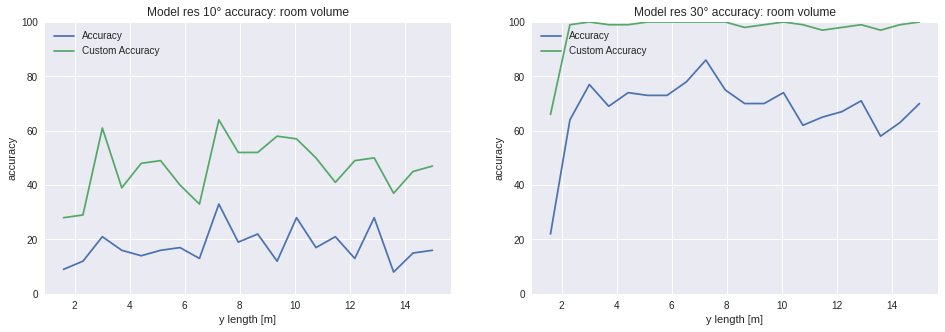

In [ ]:
# Plotting the results
plt.figure(figsize=(16,5))

# Model res 10
plt.subplot(1,2,1)
plt.plot(y_steps, accRes10_RV)
plt.plot(y_steps, custAccRes10_RV)
plt.title('Model res 10° accuracy: room volume')
plt.ylabel('accuracy')
plt.xlabel('y length [m]')
plt.ylim([0,100])
plt.legend(['Accuracy', 'Custom Accuracy'], loc='upper left')

# Model res 30
plt.subplot(1,2,2)
plt.plot(y_steps, accRes30_RV)
plt.plot(y_steps, custAccRes30_RV)
plt.title('Model res 30° accuracy: room volume')
plt.ylabel('accuracy')
plt.xlabel('y length [m]')
plt.ylim([0,100])
plt.legend(['Accuracy', 'Custom Accuracy'], loc='upper left')

In [ ]:
%cd '/content/drive/MyDrive/Github/CNN_DOA/results_csv' 

/content/drive/.shortcut-targets-by-id/1-B6wbQJimyIAQNh3Ccp578yl6uudDF9j/CNN_DOA/results_csv


In [ ]:
# Creating csv file for results
header = ['test_range', 'accuracy'] # Columns' names

# Exporting data for model res 30°
with open('vol_res30.csv', 'w') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)

    for i in range(0, len(custAccRes30_RV)):
      row = [y_steps[i], custAccRes30_RV[i]]
      # write the data
      writer.writerow(row)

# Exporting data for model res 10°
with open('vol_res10.csv', 'w') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)

    for i in range(0, len(custAccRes10_RV)):
      row = [y_steps[i], custAccRes10_RV[i]]
      # write the data
      writer.writerow(row)

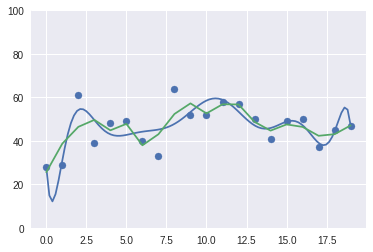

In [ ]:
# TESTING polynomial fitting (skip/remove)
from scipy.signal import savgol_filter
custAccRes10_RV = np.asarray(custAccRes10_RV)
x = np.arange(0,20)
y = custAccRes10_RV

y_sav = savgol_filter(y, 5, 2)

mymodel = np.poly1d(np.polyfit(x, y, 11))
myline = np.linspace(0, 19, 100)
plt.scatter(x, y)
plt.plot(myline, mymodel(myline))
plt.plot(y_sav)
plt.ylim([0,100])
plt.show() 

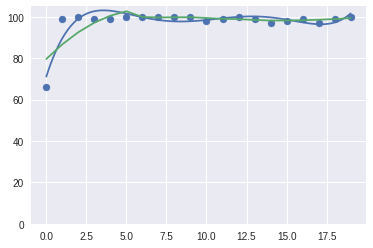

In [ ]:
# TESTING (skip)
custAccRes30_RV = np.asarray(custAccRes30_RV)
x = np.arange(0,20)
y = custAccRes30_RV
y_sav = savgol_filter(y, 11, 2)

mymodel = np.poly1d(np.polyfit(x, y, 5))
myline = np.linspace(0, 19, 100)
plt.scatter(x, y)
plt.plot(myline, mymodel(myline))
plt.plot(y_sav)
plt.ylim([0,105])
plt.show() 

## Source distance

In this test we move radially the sources starting from near positions from the microphones' center to far positions.

The range of the source distance goes from 0.14 [m] to 6.94 [m] subdivided in 20 equally spaced steps.d

In [ ]:
# Testing range
source_distances = np.linspace(0.14, 6.94, num = 20)
print(source_distances)

[0.14       0.49789474 0.85578947 1.21368421 1.57157895 1.92947368
 2.28736842 2.64526316 3.00315789 3.36105263 3.71894737 4.07684211
 4.43473684 4.79263158 5.15052632 5.50842105 5.86631579 6.22421053
 6.58210526 6.94      ]


In [ ]:
rootdir_SD = '/content/drive/MyDrive/Github/CNN_DOA/Dataset/SOURCE_DISTANCE'

# Compute accuracies
accRes30_SD, custAccRes30_SD, accRes10_SD, custAccRes10_SD = accuracyGenerator(rootdir_SD, modelRes30, modelRes10, sr, duration)

/usr/local/lib/python3.7/dist-packages/librosa/util/utils.py:200: UserWarning: librosa.util.frame called with axis=-1 on a non-contiguous input. This will result in a copy.
  "on a non-contiguous input. This will result in a copy.".format(axis)


4/4 [==============================] - 0s 13ms/step - loss: 10.5247 - accuracy: 0.0900


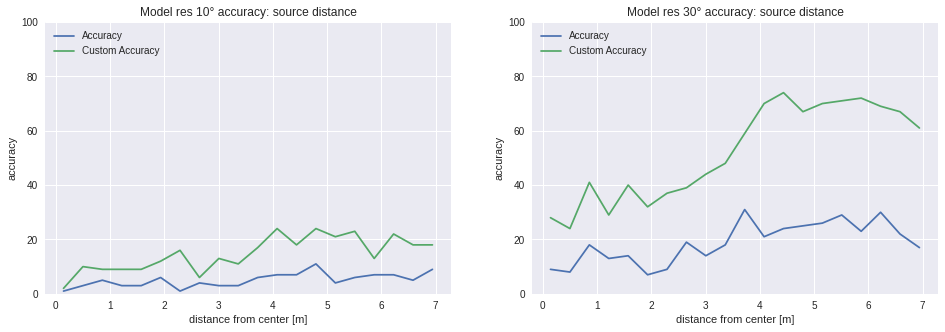

In [ ]:
# Plotting results
plt.figure(figsize=(16,5))

# Model res 10
plt.subplot(1,2,1)
plt.plot(source_distances, accRes10_SD)
plt.plot(source_distances, custAccRes10_SD)
plt.title('Model res 10° accuracy: source distance')
plt.ylabel('accuracy')
plt.xlabel('distance from center [m]')
plt.ylim([0,100])
plt.legend(['Accuracy', 'Custom Accuracy'], loc='upper left')

# Model res 30
plt.subplot(1,2,2)
plt.plot(source_distances, accRes30_SD)
plt.plot(source_distances, custAccRes30_SD)
plt.title('Model res 30° accuracy: source distance')
plt.ylabel('accuracy')
plt.xlabel('distance from center [m]')
plt.ylim([0,100])
plt.legend(['Accuracy', 'Custom Accuracy'], loc='upper left')

In [ ]:
%cd '/content/drive/MyDrive/Github/CNN_DOA/results_csv' 

/content/drive/.shortcut-targets-by-id/1-B6wbQJimyIAQNh3Ccp578yl6uudDF9j/CNN_DOA/results_csv


In [ ]:
# Creating csv file for results
header = ['test_range', 'accuracy'] # Columns' names

# Exporting data for model res 30°
with open('source_res30.csv', 'w') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)

    for i in range(0, len(custAccRes30_SD)):
      row = [source_distances[i], custAccRes30_SD[i]]
      # write the data
      writer.writerow(row)

# Exporting data for model res 10°
with open('source_res10.csv', 'w') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)

    for i in range(0, len(custAccRes10_SD)):
      row = [source_distances[i], custAccRes10_SD[i]]
      # write the data
      writer.writerow(row)

## Receiver position

In this test we move the experimental strumentation from the center of the room at mid height to top-right corner at floor height.

The range goes from the microphones' position of [4.82, 3.52, 1.5] [m] to [8, 5.4, 0.14] [m] subdivided in 20 equally spaced steps. As an unique parameter we use the distance from the first position.

In [ ]:
p_i = [4.82, 3.52, 1.5] # Inital position
p_f = [8, 5.4, 0.14] # Final position
steps = 20 # Number of subdivisions
# Spanning over the three dimensions
positions = np.asarray([np.linspace(p_i[0], p_f[0], steps), np.linspace(p_i[1], p_f[1], steps), np.linspace(p_i[2], p_f[2], steps)]).T

# Computing the distances from p_i, first position
distances = []
for pos in positions:
  # Euclidean distance
  dist = np.sqrt(np.power(p_i[0] - pos[0], 2) + np.power(p_i[0] - pos[0], 2) + np.power(p_i[0] - pos[0], 2))
  distances.append(dist)

print(distances)

[0.0, 0.2898906088457385, 0.579781217691477, 0.8696718265372154, 1.159562435382954, 1.4494530442286924, 1.7393436530744308, 2.029234261920168, 2.319124870765908, 2.6090154796116445, 2.8989060884573847, 3.1887966973031214, 3.47868730614886, 3.7685779149945984, 4.058468523840337, 4.348359132686075, 4.638249741531814, 4.928140350377553, 5.218030959223291, 5.507921568069029]


In [ ]:
rootdir_RP = '/content/drive/MyDrive/Github/CNN_DOA/Dataset/RECEIVER_POS'

accRes30_RP, custAccRes30_RP, accRes10_RP, custAccRes10_RP = accuracyGenerator(rootdir_RP, modelRes30, modelRes10, sr, duration)

/usr/local/lib/python3.7/dist-packages/librosa/util/utils.py:200: UserWarning: librosa.util.frame called with axis=-1 on a non-contiguous input. This will result in a copy.
  "on a non-contiguous input. This will result in a copy.".format(axis)


4/4 [==============================] - 0s 13ms/step - loss: 9.3158 - accuracy: 0.1400


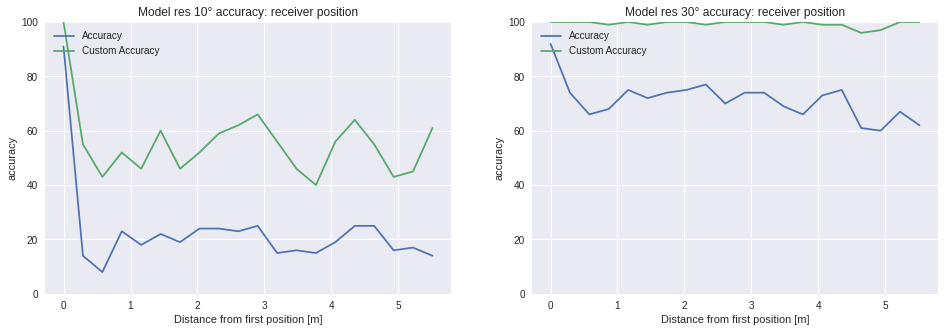

In [ ]:
# Plotting results
plt.figure(figsize=(16,5))

# Model res 10
plt.subplot(1,2,1)
plt.plot(distances, accRes10_RP)
plt.plot(distances, custAccRes10_RP)
plt.title('Model res 10° accuracy: receiver position')
plt.ylabel('accuracy')
plt.xlabel('Distance from first position [m]')
plt.ylim([0,100])
plt.legend(['Accuracy', 'Custom Accuracy'], loc='upper left')

# Model res 30
plt.subplot(1,2,2)
plt.plot(distances, accRes30_RP)
plt.plot(distances, custAccRes30_RP)
plt.title('Model res 30° accuracy: receiver position')
plt.ylabel('accuracy')
plt.xlabel('Distance from first position [m]')
plt.ylim([0,100])
plt.legend(['Accuracy', 'Custom Accuracy'], loc='upper left')

In [ ]:
%cd '/content/drive/MyDrive/Github/CNN_DOA/results_csv' 

/content/drive/.shortcut-targets-by-id/1-B6wbQJimyIAQNh3Ccp578yl6uudDF9j/CNN_DOA/results_csv


In [ ]:
# Creating csv file for results
header = ['test_range', 'accuracy'] # Columns' names

# Exporting data for model res 30°
with open('rec_res30.csv', 'w') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)

    for i in range(0, len(custAccRes30_RP)):
      row = [distances[i], custAccRes30_RP[i]]
      # write the data
      writer.writerow(row)

# Exporting data for model res 10°
with open('rec_res10.csv', 'w') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)

    for i in range(0, len(custAccRes10_RP)):
      row = [distances[i], custAccRes10_RP[i]]
      # write the data
      writer.writerow(row)